In [1]:
# FOR MASK RCNN / COCO -----------------------------------------
# run this - needed for the Coco Dataset 
# pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
# repo for it: https://github.com/philferriere/cocoapi
 
# http://cocodataset.org/#download
# from above, download 2017 Train/Val annotations
# 2017 Val images
# put it in a folder named 'data' or edit dataset cell (last one w/code) 

import torch
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader

from pycocotools.coco import COCO

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, os, json
import numpy as np

import cv2
import binascii
import scipy
import scipy.misc
import scipy.cluster
import webcolors
from helper_fcns import *

%matplotlib inline

to_pil = transforms.ToPILImage() #to_pil(image.squeeze().cpu()).show()

# Gets the GPU if there is one
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Mask R-CNN

In [2]:
# Network
# https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
network = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
network.eval();

In [3]:
# Coco Dataset
coco_val = torchvision.datasets.CocoDetection("data/val2017", annFile="data/annotations/instances_val2017.json",
                                             transform=transforms.ToTensor())

labels = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair dryer', 'toothbrush'
] # list of labels in CocoDetection
len(labels)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


91

In [4]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# haven't really looked at that much yet. might help a lot

# image sizes
for i in range(5):
    print(coco_val[i][0].shape)
#coco_val[2][0] # 2nd instance -- 0 = image (1 = segmentation)

torch.Size([3, 426, 640])
torch.Size([3, 640, 586])
torch.Size([3, 483, 640])
torch.Size([3, 500, 375])
torch.Size([3, 640, 428])


In [5]:
j = 2507 # which image
image = coco_val[j][0].unsqueeze(0).to(device)
with torch.no_grad(): # to help keep CUDA memory free (hopefully)
    output = network(image)[0]
print(output.keys())
print("number of boxes/labels", len(output['labels']))

dict_keys(['boxes', 'labels', 'scores', 'masks'])
number of boxes/labels 23


# of Boxes: 23
Box #0 :  orange 98.7223% ,  64143
Box #1 :  orange 97.8560% ,  65234
Box #2 :  orange 95.3515% ,  71261
Box #3 :  orange 90.1156% ,  15536
Box #4 :  bowl 86.7686% ,  238157


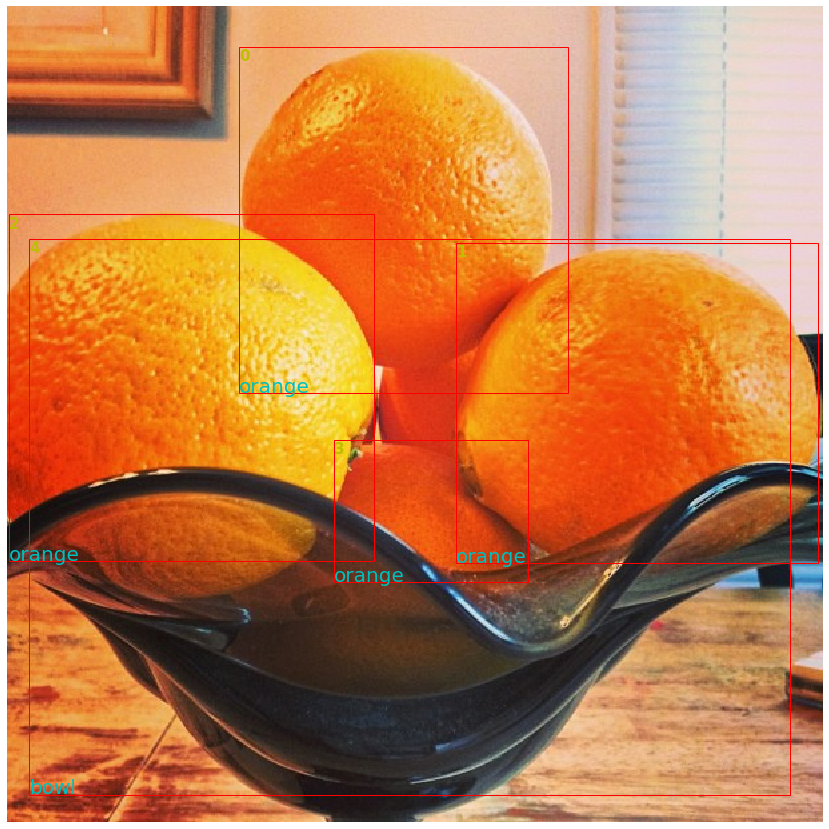

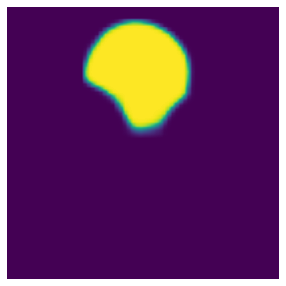

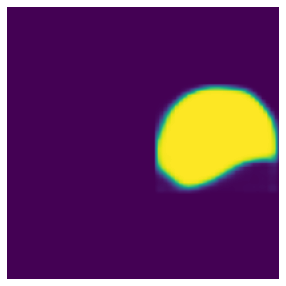

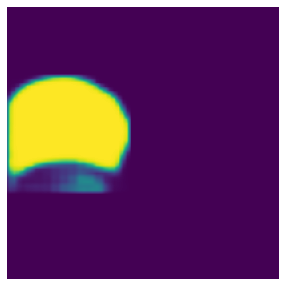

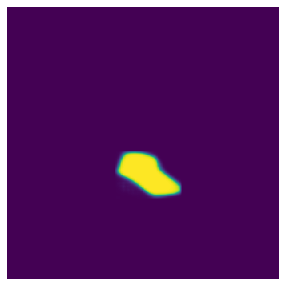

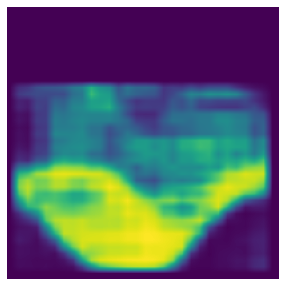

{'bowl', 'orange'}

<Figure size 432x288 with 0 Axes>

In [6]:
score_threshold = 0.75

# plot image with boxes
to_plot_image = image.cpu().squeeze().numpy().transpose(1, 2, 0)
scores = output['scores'].cpu()
length = len(scores)

fig = plt.figure(figsize=(15,15))
plt.imshow(to_plot_image)
plt.axis('off')
print('# of Boxes:', len(output['boxes']))

# go through each box
i = 0
while i < length and scores[i] > score_threshold:
    box = [output['boxes'][i][j].cpu().item() for j in range(4)] # or output['boxes'][i].cpu()
    width = box[2] - box[0] # of box
    height = box[3] - box[1] # of box
    label = labels[output['labels'][i].item()]
    #if height < 10 or width < 10 or area < 50: continue 
    
    
    # add a rectangle ((x,y), w, h)
    fig.get_axes()[0].add_patch(matplotlib.patches.Rectangle((box[0], box[1]), 
                                                             width, height, fill=False, 
                                                             color='r', linewidth=1))
    plt.annotate(i, xy=(box[0], box[1]+10), color='y', fontsize=15, fontweight='semibold') # box #
    plt.annotate(label, xy=(box[0], box[1]+height-1), color='c', fontsize=20) # box label
    
    print('Box #'+ str(i), ": ", label,  
              "{:.4f}".format(scores[i].item()*100)+"%", ", ", int(width*height)) # print info of box
    i += 1
# end - while

for j in range(i):
    show_mask(output, j, size=(5,5))

plt.savefig(os.path.join('pics', 'hi.png')) # make sure you have a pics folder

set([labels[output['labels'][j]] for j in range(i)]) # all different labels

In [7]:
score_threshold = 0.75

# plot image with boxes
to_plot_image = image.cpu().squeeze().numpy().transpose(1, 2, 0)
scores = output['scores'].cpu()

# Attempt to cut out the background
img  = np.uint8(image.cpu().squeeze().numpy().transpose(1, 2, 0)*255)
grab_cut_img = grabCutForeground(img)
# ret = imageSegmentationForeground(img)

# grab all the boxes and labels for the image
allBoxes = [[output['boxes'][i][k].cpu().item() for k in range(4)] for i in range(len(output['boxes']))]
allLabels = [labels[output['labels'][i].item()] for i in range(len(allBoxes))]
allMasks = [output['masks'][i].cpu().squeeze() for i in range(len(allBoxes))]

# only keep the boxes/labels that aren't completely blacked out
(retBoxes, retLabels, retMasks, retScores) = getRemainingBoxesAndLabels(grab_cut_img, allBoxes, allLabels, allMasks, scores, score_threshold)

colorsForRetBoxes = []
for box in retBoxes:
    colorsForRetBoxes.append(getObjectColor(img, box))
colorsForRetBoxes

['orangered', 'orangered', 'chocolate', 'chocolate', 'chocolate']

In [8]:
# go through each pair of boxes
length = len(retScores)
i = 0
j = 1
# stores tuples in the form of (labelA, labelB, indexA, indexB, phraseList)
results = []
failed = []
while i < length-1 and retScores[i] > score_threshold:
    j = 1
    while j < length and retScores[j] > score_threshold:
        if j == i:
            j += 1
            continue
            
        labelA = retLabels[i]
        boxA = retBoxes[i]
        
        labelB = retLabels[j]
        boxB = retBoxes[j]
        
        # lst may be none
        lst = getPhraseList(boxA, boxB)
        if lst is not None:
            results.append((labelA, labelB, i, j, lst))
        else:
            failed.append((labelA, labelB, i, j, lst))
        j += 1
        # end - while
    i += 1
# end - while

In [9]:
# save to json so nlp notebook can open them
with open('results.json', 'w') as ot:
    json.dump(results, ot)

with open('failed.json', 'w') as ot:
    json.dump(failed, ot)

# For 100 Images

In [14]:
score_threshold = 0.75
total_everything = []

for img_num in range(200):
    try:
        if img_num % 10 == 0: print(img_num)
        image = coco_val[img_num][0].unsqueeze(0).to(device)
        with torch.no_grad(): # to help keep CUDA memory free (hopefully)
            output = network(image)[0]

        scores = output['scores'].cpu()

        # Attempt to cut out the background
        img = np.uint8(image.cpu().squeeze().numpy().transpose(1, 2, 0)*255)
        grab_cut_img = grabCutForeground(img)
        # ret = imageSegmentationForeground(img)

        # grab all the boxes and labels for the image
        allBoxes = [[output['boxes'][i][k].cpu().item() for k in range(4)] for i in range(len(output['boxes']))]
        allLabels = [labels[output['labels'][i].item()] for i in range(len(allBoxes))]
        allMasks = [output['masks'][i].cpu().squeeze() for i in range(len(allBoxes))]

        # only keep the boxes/labels that aren't completely blacked out
        (retBoxes, retLabels, retMasks, retScores) = getRemainingBoxesAndLabels(grab_cut_img, allBoxes, allLabels, allMasks, scores, score_threshold)

        colorsForRetBoxes = []
        for box in retBoxes:
            colorsForRetBoxes.append(getObjectColor(img, box))

        # go through each pair of boxes
        length = len(retScores)
        i = 0
        j = 1
        # stores tuples in the form of (labelA, labelB, indexA, indexB, phraseList)
        results = []
        failed = []
        while i < length-1 and retScores[i] > score_threshold:
            j = 1
            while j < length and retScores[j] > score_threshold:
                if j == i:
                    j += 1
                    continue

                labelA = retLabels[i]
                boxA = retBoxes[i]

                labelB = retLabels[j]
                boxB = retBoxes[j]

                # lst may be none
                lst = getPhraseList(boxA, boxB)
                if lst is not None:
                    results.append((labelA, labelB, i, j, lst))
                else:
                    failed.append((labelA, labelB, i, j, lst))
                j += 1
                # end - while
            i += 1
        # end - while
        retScores = [x.cpu().item() for x in retScores]
        total_everything.append([img_num, results, failed, colorsForRetBoxes, retLabels, retScores])
    except:
        print(img_num, "failed")

0
5 failed
10
20
30
40
45 failed
50
60
70
80
87 failed
90
92 failed
100
110
120
130
140
150
153 failed
160
170
180
190


In [15]:
# Save results
with open('everything.json', 'w') as ot:
    json.dump(total_everything, ot)

In [12]:
"""Get results from NLP Notebook""";

'Get results from NLP Notebook'